In [1]:
from netCDF4 import Dataset,netcdftime,num2date
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib
import time
import datetime
import pandas as pd
#import mldCalc
import readData
import newNCARread
import sys
import fastMLD
import fastBLD

from matplotlib.ticker import MultipleLocator, FormatStrFormatter
from matplotlib.patches import Rectangle
import xarray as xray
from mpas_xarray import preprocess_mpas, remove_repeated_time_index

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (16, 10) # Large figures
dpi=200;

In [2]:
### axis_font = {'fontname':'Arial', 'size':'18'}    
title_font = {'fontname':'Arial', 'size':'20', 'color':'black', 'weight':'normal'}
matplotlib.rc('xtick', labelsize=20)
matplotlib.rc('ytick', labelsize=20)

In [3]:
def find_nearest(array,value):
    idx = (np.abs(array-value)).argmin()
    return idx

In [4]:
hexcols = ['#332288', '#88CCEE', '#44AA99', '#117733', '#999933', '#DDCC77', 
           '#CC6677', '#882255', '#AA4499', '#661100', '#6699CC', '#AA4466',
           '#4477AA']

greysafecols = ['#809BC8', '#FF6666', '#FFCC66', '#64C204']

xarr = [[12], 
        [12, 6], 
        [12, 6, 5], 
        [12, 6, 5, 3], 
        [0, 1, 3, 5, 6], 
        [0, 1, 3, 5, 6, 8], 
        [0, 1, 2, 3, 5, 6, 8], 
        [0, 1, 2, 3, 4, 5, 6, 8], 
        [0, 1, 2, 3, 4, 5, 6, 7, 8], 
        [0, 1, 2, 3, 4, 5, 9, 6, 7, 8], 
        [0, 10, 1, 2, 3, 4, 5, 9, 6, 7, 8], 
        [0, 10, 1, 2, 3, 4, 5, 9, 6, 11, 7, 8]]

# get specified nr of distinct colours in HTML hex format.
# in: nr - number of colours [1..12]
# returns: list of distinct colours in HTML hex
def get_distinct(nr):

    #
    # check if nr is in correct range
    #
    
    if nr < 1 or nr > 12:
        print "wrong nr of distinct colours!"
        return

    #
    # get list of indices
    #
    
    lst = xarr[nr-1]
    
    #
    # generate colour list by stepping through indices and looking them up
    # in the colour table
    #

    i_col = 0
    col = [0] * nr
    for idx in lst:
        col[i_col] = hexcols[idx]
        i_col+=1
    return col

In [5]:
dayval = 9
hourstart = 6
hourend = 12

#These values are for the daily averaged plots (bottom and top of plot)
bigZvalBot = -43
bigZvalTop = -2

#choose number of ticks on x-axis of daily avg plots
nticks = 4

In [6]:
cvs1 = get_distinct(4)

lescolor = cvs1[0]
leslinethick = '4'
leslinstyle = 'solid'

In [7]:
testcase = 'ConvectSaltWind'

## Load LES profile data

t1=time.time()
sys.path.append('/users/lvanroekel/python_scripts/')

reload(newNCARread)


nz=256
nscl=2
base2='/net/scratch1/lvanroekel/NCARLES/'
t=newNCARread.turbRead(base2,testcase,'hist',nz,nscl,['txym','uxym','vxym',\
                                        'wtle','uwle','vwle','z','zz','wxym','ups','vps','wps','utle','vtle', \
                                                       'tps','wtDT','wwT','tpcp','spcp','tpress','wTdot','SGSWT', \
                                                      't_rprod','t_wq','t_wp','t_tau','t_tran','t_buoy',\
                                                      't_diss','t_sprod','wtDT','uwsb','vwsb'])
            
txym=t[0][:,1:nz+1,:];
uxym=t[1][:,1:nz+1]
vxym=t[2][:,1:nz+1]
wtle=t[3][:,:,0]
if nscl > 1:
    wsle=t[3][:,:,1]
wwle=t[11][:,:]
uwle=t[4][:,:]
vwle=t[5][:,:]
uule=t[9][:,:]
vvle=t[10][:,:]
utle=t[12][:,:]
vtle=t[13][:,:]
ztopLES=t[6][:,0:nz+1]
zmidLES=t[7][:,1:nz+1]
wxym=t[8][:,1:nz+1]
tps=t[14][:,:]
wtDT=t[15][:,:]
wwT=t[16][:,:]
tpcp=t[17][:,:]
spcp=t[18][:,:]
tpress=t[19][:,:]
wtdot=t[20][:,:]
sgswt=t[21][:,:]
t_rprod=t[22][:,:]
t_wq=t[23][:,:]
t_wp=t[24][:,:]
t_tau=t[25][:,:]
t_tran=t[26][:,:]
t_buoy=t[27][:,:]
t_diss=t[28][:,:]
t_sprod=t[29][:,:]
wtdt=t[30][:,:]
uwsb=t[31][:,:]
vwsb=t[32][:,:]
tarr=t[33]

time2LES=tarr
nt = len(tarr)
time2LES=np.zeros((len(tarr),nz))
for i in range(nz-1):
    time2LES[:,i]=tarr

print time.time() - t1

113.037819862


In [8]:
#Create LES dataset for plotting and averaging ease.

tarr = time2LES[:,0] / 86400
dtimes = [datetime.datetime(2000,1,1,0,0,0) + datetime.timedelta(x) for x in tarr]
Scl = 0
avInt = '1H'


if nscl == 1:
    dsLES = xray.Dataset({'temp':(['Time','zm'], txym[:,:,0]-273.15), 'U':(['Time','zm'],uxym), \
                         'V':(['Time','zm'],vxym), 'wt':(['Time','zt'], wtle), 'wb':(['Time','zt'], 9.8*2E-4*wtle), \
                         'ww':(['Time','zt'], wwle), 'uw':(['Time','zt'], uwle), 'vw':(['Time','zt'], vwle), \
                         'uu':(['Time','zt'], uule), 'vv':(['Time','zt'], vvle), 'ut':(['Time','zt'], utle), \
                         'vt':(['Time','zt'], vtle), 'ztop':(['Time','zt'], ztopLES), 'zmid':(['Time','zm'], zmidLES), \
                         'W':(['Time','zt'], wxym), 'tps':(['Time','zm'], tps), 'wtDT':(['Time','zt'], wtDT), \
                         'wwT':(['Time','zt'], wwT), 'tpcp':(['Time','zm'], tpcp), 'tpress':(['Time','zm'], tpress), \
                         'wtdot':(['Time','zt'], wtdot), 'wtsgs':(['Time','zt'], sgswt), \
                         't_rprod':(['Time','zm'], t_rprod), 't_wq':(['Time','zt'], t_wq), 't_wp':(['Time','zt'], t_wp), \
                         't_tau':(['Time','zt'], t_tau), 't_tran':(['Time','zt'], t_tran), \
                         't_buoy':(['Time','zt'], t_buoy), 't_diss':(['Time','zt'], t_diss), \
                         't_sprod':(['Time','zt'], t_sprod), 'wtdt':(['Time','zt'], wtdt), \
                         'uwsgs':(['Time','zt'], uwsb), 'vwsgs':(['Time','zt'], vwsb)}, \
                        coords={'Time':dtimes, 'zt': ztopLES[0,:nz], 'zm': zmidLES[0,:]})
    dsLES['b'] = xray.DataArray(9.8*(2E-4*(txym[:,:,0] - 278.15)), \
                                coords=[dsLES.Time, dsLES.zm], dims=['Time', 'zm'])
    
else:
    dsLES = xray.Dataset({'temp':(['Time','zm'], txym[:,:,0]-273.15), 'salt':(['Time','zm'], txym[:,:,1]) \
                          , 'U':(['Time','zm'],uxym), \
                         'V':(['Time','zm'],vxym), 'wt':(['Time','zt'], wtle), 'ws':(['Time','zt'], wsle), \
                         'wb':(['Time','zm'], 9.8*(2E-4*wtle - 8E-4*wsle)), \
                         'ww':(['Time','zt'], wwle), 'uw':(['Time','zt'], uwle), 'vw':(['Time','zt'], vwle), \
                         'uu':(['Time','zt'], uule), 'vv':(['Time','zt'], vvle), 'ut':(['Time','zt'], utle[:,:,Scl]), \
                         'vt':(['Time','zm'], vtle[:,:,Scl]), 'ztop':(['Time','zt'], ztopLES[:,:nz]), \
                          'zmid':(['Time','zm'], zmidLES), \
                         'W':(['Time','zt'], wxym), 'tps':(['Time','zm'], tps[:,:,Scl]),'sps':(['Time','zm'],tps[:,:,1]), \
                          'wtDT':(['Time','zt'], wtDT[:,:,Scl]), \
                         'wwT':(['Time','zt'], wwT[:,:,Scl]),'wwS':(['Time','zt'], wwT[:,:,1]), 'tpcp':(['Time','zm'], tpcp[:,:,0]), \
                          'tpress':(['Time','zm'], tpress[:,:,Scl]),'spress':(['Time','zt'],wtdot[:,:,1]), \
                         'wtdot':(['Time','zt'], wtdot[:,:,Scl]), 'wtsgs':(['Time','zm'], sgswt[:,:,Scl]), \
                         't_rprod':(['Time','zm'], t_rprod), 't_wq':(['Time','zt'], t_wq), 't_wp':(['Time','zt'], t_wp), \
                         't_tau':(['Time','zt'], t_tau), 't_tran':(['Time','zt'], t_tran), \
                         't_buoy':(['Time','zt'], t_buoy), 't_diss':(['Time','zt'], t_diss), \
                         't_sprod':(['Time','zt'], t_sprod), 'wtdt':(['Time','zt'], wtdt[:,:,Scl]), \
                         'uwsgs':(['Time','zt'], uwsb), 'vwsgs':(['Time','zt'], vwsb), 'spcp':(['Time','zt'], spcp[:,:,0])}, \
                        coords={'Time':dtimes, 'zt': ztopLES[0,:nz], 'zm': zmidLES[0,:]})
    saltref = txym[0,:15,1].mean()
    dsLES['b'] = xray.DataArray(9.8*(2E-4*(txym[:,:,0] - 278.15) - 8E-4*(txym[:,:,1] - saltref)), \
                                coords=[dsLES.Time, dsLES.zm], dims=['Time', 'zm'])
dsLESAv = dsLES.resample(avInt, 'Time')

In [9]:
nvals = dsLESAv.dims['Time']
cstar = 10.0
Cmstar = 3.3

if testcase == 'ConvectNew':
    ustar = 0.0*np.ones(len(dsLESAv.Time.values))
    tempsfcflux = -75./4.2E6*np.ones(len(dsLESAv.Time.values))
    saltsfcflux = 0.0*np.ones(len(dsLESAv.Time.values))
    buoyflux = 9.8*(2E-4*tempsfcflux - 8E-4*saltsfcflux)*np.ones(len(dsLESAv.Time.values))
if testcase == 'ConvectSaltWind':
        ustar = 0.01*np.ones(len(dsLESAv.Time.values))
        tempsfcflux = -75./4.2E6*np.ones(len(dsLESAv.Time.values))
        saltsfcflux = 1.585E-8*35*np.ones(len(dsLESAv.Time.values))
        buoyflux = 9.8*(2E-4*tempsfcflux - 8E-4*saltsfcflux)

if testcase == 'noMLdiurnal':
    ustar = 0.0*np.ones(len(dsLESAv.Time.values))
    tempsfcflux = -75/4.2E6
    saltsfcflux = 1.585E-8*35
    bFlux1 = 9.8*(2E-4*tempsfcflux - 8E-4*saltsfcflux)
    maxD = -np.pi*(bFlux1 / (9.8*2E-4) * 4.2E6)


    swflux = [maxD * max(np.cos(2.*np.pi*((((x-dsLESAv.Time.values[0]) / np.timedelta64(1, 's'))/86400) - 0.5)), 0) for x in dsLESAv.Time.values];
    tempsfcflux = -75/4.2E6*np.ones(len(swflux)) + np.array(swflux)/4.2E6
    saltsfcflux = 1.585E-8*35*np.ones(len(swflux))
    buoyflux = 9.8*(2E-4*tempsfcflux - 8E-4*saltsfcflux)
if testcase == 'AllForcingML':
    ustar = 0.01*np.ones(len(dsLESAv.Time.values))
    tempsfcflux = -75/4.2E6
    saltsfcflux = 1.585E-8*35
    bFlux1 = 9.8*(2E-4*tempsfcflux - 8E-4*saltsfcflux)
    maxD = -np.pi*(bFlux1 / (9.8*2E-4) * 4.2E6)

    swflux = [maxD * max(np.cos(2.*np.pi*((((x-dsLESAv.Time.values[0]) / np.timedelta64(1, 's'))/86400) - 0.5)), 0) for x in dsLESAv.Time.values];

    tempsfcflux = -75/4.2E6*np.ones(len(swflux)) + np.array(swflux)/4.2E6
    saltsfcflux = 1.585E-8*35*np.ones(len(swflux))
    buoyflux = 9.8*(2E-4*tempsfcflux - 8E-4*saltsfcflux)

bldLES1=np.zeros(nvals)
bldLES2=np.zeros(nvals)
bldLES3=np.zeros(nvals)
bldLES4=np.zeros(nvals)
bldLES5=np.zeros(nvals)
bldKPP=np.zeros(nvals)


nz = dsLES.dims['zm']
ws = np.zeros((nvals, nz-1))
wm = np.zeros((nvals, nz-1))
wtloc1 = np.zeros((nvals,nz-1))
wtloc2 = np.zeros((nvals,nz-1))

wtnloc1 = np.zeros((nvals,nz-1))
wtnloc2 = np.zeros((nvals,nz-1))
wtnloc3 = np.zeros((nvals,nz-1))
wtnloc4 = np.zeros((nvals,nz-1))
wtnloc5 = np.zeros((nvals,nz-1))

uwloc1 = np.zeros((2,nvals,nz-1))
uwloc2 = np.zeros((2,nvals,nz-1))

uwnloc1 = np.zeros((2,nvals,nz-1))
uwnloc2 = np.zeros((2,nvals,nz-1))
uwnloc3 = np.zeros((2,nvals,nz-1))
uwnloc4 = np.zeros((2,nvals,nz-1))
uwnloc5 = np.zeros((2,nvals,nz-1))

refT = 5
refS = dsLESAv.salt[0,0:10].mean()
shiftVal = 0

for i in range(nvals):
    
    minwBspot=dsLESAv.wb[i,:].values.argmin()
    minwB = 0.1*dsLESAv.wb[i,:].values.min()
    j = minwBspot + 1
    while dsLESAv.wb[i,j].values < minwB:
        j += 1
    bldLES1[i] = dsLESAv.ztop[i,minwBspot].values

    bldLES2[i] = dsLESAv.ztop[i,j].values
    
    j = minwBspot - 1
    while dsLESAv.wb[i,j].values < minwB:
        j -= 1
    bldLES3[i] = dsLESAv.ztop[i,j].values
    
#    bldLoc = abs(ztopLES[i,:] - bldLES[i]).argmin() + 1
    tkeTot = 0.5*(dsLESAv.uu[i,:].values + dsLESAv.vv[i,:].values + dsLESAv.ww[i,:].values)
    tkeMax = max(tkeTot)
    
    minTKE = 0.05*tkeMax
    j = 0
#    if bldLoc != 1:
    while tkeTot[j] > minTKE and j < nz-1:
        j += 1
    if j > 200:
        j = 1
        
    bldLES4[i] = dsLESAv.ztop[i,j].values
    
    totFlux = abs((dsLESAv.uw[i,:].values) + (dsLESAv.vw[i,:].values))


        
delta = np.zeros((len(tarr),1))

delta = bldLES2 - bldLES3

dsLESAv['H'] = xray.DataArray(bldLES4, coords = [dsLESAv.Time], dims=['Time'])
dsLESAv['bldMinWB'] = xray.DataArray(bldLES1, coords = [dsLESAv.Time], dims=['Time'])
saltref = txym[0,:15,1].mean()

dsLES['b'] = xray.DataArray(9.8*(2e-4*(dsLES.temp - 5) - 8E-4*(dsLES.salt - saltref)), coords = [dsLES.Time, dsLES.zm], \
                           dims=['Time','zm'])

dsLESAv['b'] = xray.DataArray(9.8*(2e-4*(dsLESAv.temp - 5) - 8E-4*(dsLESAv.salt - 35)),  \
                              coords = [dsLESAv.Time, dsLESAv.zm], dims=['Time','zm'])


    
nvals = dsLESAv.dims['Time'];
nz = dsLESAv.dims['zm'];

N2T = (dsLESAv.b[:nvals,:nz-1].values - dsLESAv.b[:nvals,1:].values) / (dsLESAv.zmid[:nvals,:nz-1].values - \
                                                                        dsLESAv.zmid[:nvals,1:].values)
N2T = np.vstack([N2T.T, np.zeros(nvals)]).T

inds = np.where(N2T < 0)
N2T[inds] = 0.0
dsLESAv['N2'] = xray.DataArray(np.sqrt(N2T), \
                            coords=[dsLESAv.Time, dsLESAv.zm], dims=['Time','zm']);


for i in range(nvals-1):
    bldKPP[i]=fastBLD.computeBLD(2,0.25,dsLESAv.zmid[i:i+1,:].values, dsLESAv.ztop[i:i+1,:].values,0.1,True, \
                               dsLESAv.temp[i:i+1,:].values, dsLESAv.salt[i:i+1,:].values,  \
                                     dsLESAv.U[i:i+1,:].values, dsLESAv.V[i:i+1,:].values, \
                               np.roll(dsLESAv.N2[i:i+1,:].values,shiftVal), 0, buoyflux[i], \
                               ustar[i], refT, refS, True)
    
    sig = -dsLESAv.ztop[i,1:] / bldKPP[i]
    inds = np.where(sig > 0.1)
    sig[:] = 0.1
    
    wstar = (abs(buoyflux[i])*abs(bldKPP[i]))**(1./3.)
    
    if ustar[i] == 0:
        ws[i,:] = 0.4*(98.96*0.4*sig*abs(bldKPP[i])*abs(buoyflux[i]))**(1./3.)
    else:
        zeta = sig*bldKPP[i]*0.4*buoyflux[i] / ustar[i]**3.
        if np.any(zeta >= 0):
            inds = np.where(zeta >= 0)
            ws[i,inds] = 0.4*ustar[i] / (1. + 5.*zeta[inds])
        if np.any((zeta < 0) & (zeta > -1)):
            inds = np.where((zeta > -1) & (zeta < 0))
            ws[i,inds] = 0.4*ustar[i] / (1 - 16.*zeta[inds])**(-1./2.)
        if np.any(zeta <= -1):
            inds = np.where(zeta <= -1)
            ws[i,inds] = 0.4*ustar[i] / (-28.86 - 98.96*zeta[inds])**(-1./3.)
            
        if np.any(zeta >= 0):
            inds = np.where(zeta >= 0)
            wm[i,inds] = 0.4*ustar[i] / (1. + 5.*zeta[inds])
        if np.any((zeta < 0) & (zeta > -0.2)):
            inds = np.where((zeta > -0.2) & (zeta < 0))
            wm[i,inds] = 0.4*ustar[i] / (1 - 16.*zeta[inds])**(-1./4.)
        if np.any(zeta <= -0.2):
            inds = np.where(zeta <= -1)
            wm[i,inds] = 0.4*ustar[i] / (1.26 - 8.38*zeta[inds])**(-1./3.)
            
    
    sig = -dsLESAv.ztop[i,1:].values / bldKPP[i]
    inds = np.where(sig > 1)
    
    shape1 = sig*(1-sig)**2.    
    shape2 = sig**(4./3.)*(1-sig)**2*(1-0.2*sig)
    shape3 = (1- sig)**2
    shape4 = 1 + (2*sig - 3)*sig**2
    shape5 = 1 - sig
    
    shape1[inds] = 0.0
    shape2[inds] = 0.0
    shape3[inds] = 0.0
    shape4[inds] = 0.0
    shape5[inds] = 0.0
    
        
    dt = dsLESAv.temp[i,:nz-1].values - dsLESAv.temp[i,1:nz].values
    
    dU = dsLESAv.U[i,:nz-1].values - dsLESAv.U[i,1:nz].values
    dV = dsLESAv.V[i,:nz-1].values - dsLESAv.V[i,1:nz].values
    
    dz = dsLESAv.zmid[i,:nz-1].values - dsLESAv.zmid[i,1:].values
    wtloc1[i,:] = -shape1 * bldKPP[i] * ws[i,:] * dt / dz
    wtloc2[i,:] = -shape2 * bldKPP[i] * ws[i,:] * dt / dz
    
    uwloc1[0,i,:] = -shape1 * bldKPP[i] * wm[i,:] * dU / dz
    uwloc1[1,i,:] = -shape1 * bldKPP[i] * wm[i,:] * dV / dz
    
    Cs = cstar * 0.4*(98.96*0.4*0.1)**(1./3.)
    Cm = Cmstar * 0.4*(8.38*0.4*0.1)**(1./3.)
    Aval = -Cm * ustar[i]**2.* ( 2.7 * wstar**3. ) / ( ustar[i]**3. + 0.6*wstar**3. )
    #crude sfc average
    inds = np.where(dsLESAv.zmid[i,:].values > - 0.1 * bldKPP[i])
    usl = dsLESAv.U[i,inds[0]].mean().values
    vsl = dsLESAv.V[i,inds[0]].mean().values
    
    cursl = np.sqrt(usl**2 + vsl**2)
    
    spot = abs(dsLESAv.ztop[i,:].values + bldKPP[i]).argmin()
    curobl = np.sqrt(dsLESAv.U[i,spot].values**2 + dsLESAv.V[i,spot].values**2)
    eU = abs(usl - dsLESAv.U[i,spot].values) / abs(cursl - curobl)
    eV = abs(vsl - dsLESAv.V[i,spot].values) / abs(cursl - curobl)
    
    vals = np.ones(255)
    inds = np.where(sig < 0.1)
#    vals[inds] = 0.0
    
    wtnloc1[i,:] = shape1 * Cs * tempsfcflux[i] * vals
    wtnloc2[i,:] = shape1 * Cs/2. * tempsfcflux[i] * vals
    wtnloc3[i,:] = shape3 * tempsfcflux[i] * vals
    wtnloc4[i,:] = shape4 * tempsfcflux[i] * vals
    wtnloc5[i,:] = shape5 * tempsfcflux[i] * vals
    
    uwnloc1[0,i,:] = shape1 * Aval * eU
    uwnloc2[0,i,:] = shape1 * Aval / 2. * eU
    uwnloc3[0,i,:] = shape3 * Aval * eU
    uwnloc4[0,i,:] = shape4 * Aval * eU
    uwnloc5[0,i,:] = shape5 * Aval * eU
    
    uwnloc1[1,i,:] = shape1 * Aval * eV
    uwnloc2[1,i,:] = shape1 * Aval / 2. * eV
    uwnloc3[1,i,:] = shape3 * Aval * eV
    uwnloc4[1,i,:] = shape4 * Aval * eV
    uwnloc5[1,i,:] = shape5 * Aval * eV
    
dsLESAv['HKPP'] = xray.DataArray(bldKPP, coords = [dsLESAv.Time], dims=['Time'])  

In [10]:
eU

0.90518287469213821

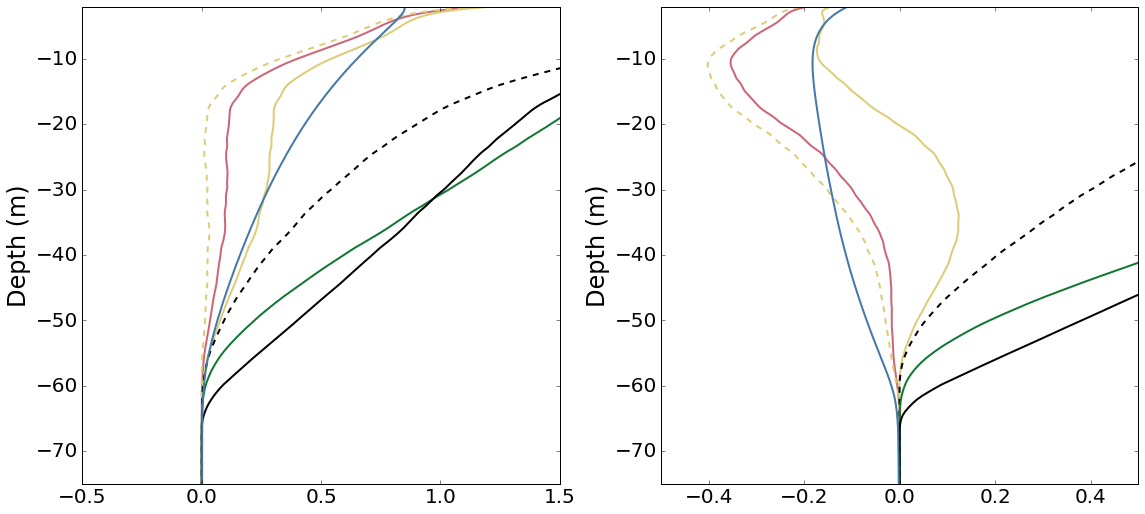

In [14]:
f, axarr = plt.subplots(1,2, sharey=False)

axarr[0].plot((-uwnloc1[1,150:200,:]/3.-uwloc1[1,150:200,:]).mean(axis=0)/abs(ustar[150:200].mean()**2), \
              dsLESAv.ztop[5,1:],linewidth=2,color=cvs1[1])
axarr[0].plot((-uwloc1[1,150:200,:]).mean(axis=0)/abs(ustar[150:200].mean()**2), \
              dsLESAv.ztop[5,1:],linewidth=2,color=cvs1[2],linestyle='dashed')
axarr[0].plot((-uwnloc1[1,150:200,:]-uwloc1[1,150:200,:]).mean(axis=0)/abs(ustar[150:200].mean()**2), \
              dsLESAv.ztop[5,1:],linewidth=2,color=cvs1[2])
axarr[0].plot((-uwnloc3[1,150:200,:]-uwloc1[1,150:200,:]).mean(axis=0)/abs(ustar[150:200].mean()**2), \
             dsLESAv.ztop[5,1:],'--k',linewidth=2)
axarr[0].plot((-uwnloc4[1,150:200,:]-uwloc1[1,150:200,:]).mean(axis=0)/abs(ustar[150:200].mean()**2), \
              dsLESAv.ztop[5,1:],linewidth=2, color=cvs1[3])
axarr[0].plot((-uwnloc5[1,150:200,:]-uwloc1[1,150:200,:]).mean(axis=0)/abs(ustar[150:200].mean()**2), \
              dsLESAv.ztop[5,1:],'k',linewidth=2)
axarr[0].plot(-dsLESAv.vw[150:200,1:].mean(axis=0).values/abs(ustar[150:200].mean()**2),dsLESAv.ztop[5,1:], \
             linewidth=2, color=cvs1[0])
axarr[0].set_ylim(-75,-2)
axarr[0].set_xlim(-0.5,1.5)
axarr[0].set_ylabel('Depth (m)',fontsize=24)

axarr[1].plot((-uwnloc1[0,150:200,:]/5.+uwloc1[0,150:200,:]).mean(axis=0)/abs(ustar[150:200].mean()**2), \
              dsLESAv.ztop[5,1:],linewidth=2,color=cvs1[1])
axarr[1].plot((uwloc1[0,150:200,:]).mean(axis=0)/abs(ustar[150:200].mean()**2), \
              dsLESAv.ztop[5,1:],linewidth=2,color=cvs1[2],linestyle='dashed')
axarr[1].plot((-uwnloc1[0,150:200,:]+uwloc1[0,150:200,:]).mean(axis=0)/abs(ustar[150:200].mean()**2), \
              dsLESAv.ztop[5,1:],linewidth=2,color=cvs1[2])
axarr[1].plot((-uwnloc3[0,150:200,:]+uwloc1[0,150:200,:]).mean(axis=0)/abs(ustar[150:200].mean()**2), \
             dsLESAv.ztop[5,1:],'--k',linewidth=2)
axarr[1].plot((-uwnloc4[0,150:200,:]+uwloc1[0,150:200,:]).mean(axis=0)/abs(ustar[150:200].mean()**2), \
              dsLESAv.ztop[5,1:],linewidth=2, color=cvs1[3])
axarr[1].plot((-uwnloc5[0,150:200,:]+uwloc1[0,150:200,:]).mean(axis=0)/abs(ustar[150:200].mean()**2), \
              dsLESAv.ztop[5,1:],'k',linewidth=2)
axarr[1].plot(dsLESAv.uw[150:200,1:].mean(axis=0).values/abs(ustar[150:200].mean()**2),dsLESAv.ztop[5,1:], \
             linewidth=2, color=cvs1[0])
axarr[1].set_ylim(-75,-2)
axarr[1].set_xlim(-0.5,.5)
axarr[1].set_ylabel('Depth (m)',fontsize=24)

#axarr[1].set_yticklabels([])
f.tight_layout()
axarr[0].set_aspect(1./axarr[0].get_data_ratio())
axarr[1].set_aspect(1./axarr[1].get_data_ratio())

#f.savefig('/usr/projects/climate/lvanroekel/LES_wind_nonlocal_ConvectSaltWind.png')

In [211]:
wtnloc1CSW = np.copy(wtnloc1)
wtnloc2CSW = np.copy(wtnloc2)
wtnloc3CSW = np.copy(wtnloc3)
wtnloc4CSW = np.copy(wtnloc4)
wtnloc5CSW = np.copy(wtnloc5)

wtloc1CSW = np.copy(wtloc1)
wtloc2CSW = np.copy(wtloc2)

In [210]:
np.copy?

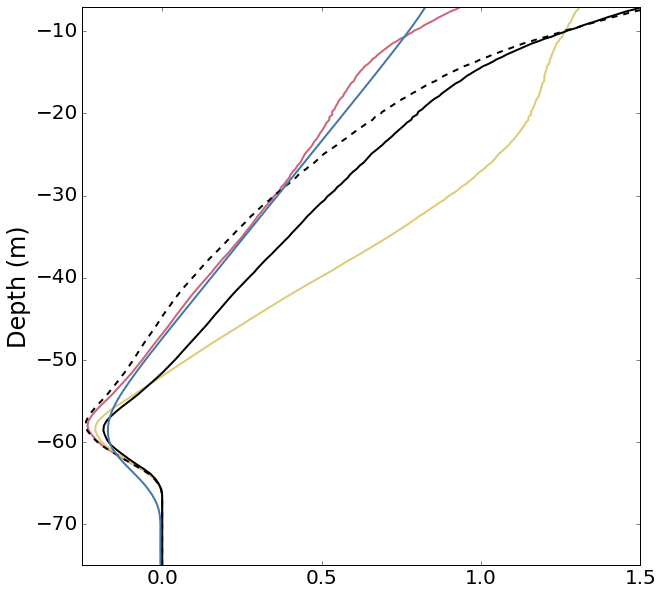

In [13]:
f, axarr = plt.subplots(1,1, sharey=False)

axarr.plot((-wtnloc1[150:200,:]/3.+wtloc1[150:200,:]).mean(axis=0)/abs(tempsfcflux[150:200].mean()), \
              dsLESAv.ztop[5,1:],linewidth=2,color=cvs1[1])
axarr.plot((-wtnloc1[150:200,:]+wtloc1[150:200,:]).mean(axis=0)/abs(tempsfcflux[150:200].mean()), \
              dsLESAv.ztop[5,1:],linewidth=2,color=cvs1[2])
axarr.plot((-wtnloc3[150:200,:]+wtloc1[150:200,:]).mean(axis=0)/abs(tempsfcflux[150:200].mean()), \
             dsLESAv.ztop[5,1:],'--k',linewidth=2)
axarr.plot((-0.85*wtnloc4[150:200,:]+wtloc1[150:200,:]).mean(axis=0)/abs(tempsfcflux[150:200].mean()), \
              dsLESAv.ztop[5,1:],linewidth=2, color=cvs1[3])
axarr.plot((-0.85*wtnloc5[150:200,:]+wtloc1[150:200,:]).mean(axis=0)/abs(tempsfcflux[150:200].mean()), \
              dsLESAv.ztop[5,1:],'k',linewidth=2)
axarr.plot(dsLESAv.wt[150:200,1:].mean(axis=0).values/abs(tempsfcflux[150:200].mean()),dsLESAv.ztop[5,1:], \
             linewidth=2, color=cvs1[0])
axarr.set_ylim(-75,-7)
axarr.set_xlim(-0.25,1.5)
axarr.set_ylabel('Depth (m)',fontsize=24)
#axarr[1].plot((-wtnloc1CSW[150:200,:]/3.+wtloc1CSW[150:200,:]).mean(axis=0)/abs(tempsfcflux[150:200].mean()), \
#              dsLESAv.ztop[5,1:],linewidth=2, color=cvs1[1])
#axarr[1].plot((-wtnloc1CSW[150:200,:]+wtloc1CSW[150:200,:]).mean(axis=0)/abs(tempsfcflux[150:200].mean()), \
#              dsLESAv.ztop[5,1:],linewidth=2,color=cvs1[2])
#axarr[1].plot((-wtnloc3CSW[150:200,:]+wtloc1CSW[150:200,:]).mean(axis=0)/abs(tempsfcflux[150:200].mean()), \
#              dsLESAv.ztop[5,1:],'--k',linewidth=2)
#axarr[1].plot((-0.85*wtnloc4CSW[150:200,:]+wtloc1CSW[150:200,:]).mean(axis=0)/abs(tempsfcflux[150:200].mean()), \
#              dsLESAv.ztop[5,1:],linewidth=2,color=cvs1[3])
#axarr[1].plot((-0.85*wtnloc5CSW[150:200,:]+wtloc1CSW[150:200,:]).mean(axis=0)/abs(tempsfcflux[150:200].mean()), \
#              dsLESAv.ztop[5,1:],'k',linewidth=2)
#axarr[1].plot(dsLESAv.wt[150:200,1:].mean(axis=0).values/abs(tempsfcflux[150:200].mean()),dsLESAv.ztop[5,1:],\
#             linewidth=2, color=cvs1[0])
#axarr[1].set_ylim(-75,-7)
#axarr[1].set_xlim(-0.25,1.5)
#axarr[1].set_yticklabels([])
#f.tight_layout()
axarr.set_aspect(1./axarr.get_data_ratio())
#axarr[1].set_aspect(1./axarr[1].get_data_ratio())

#f.savefig('/usr/projects/climate/lvanroekel/LES_new_shape_ConvectSaltWind.png')

In [161]:
ti=150
wTloc = np.zeros(256)
wTnloc = np.zeros(256)

for zi,ZZ in enumerate(dsLESAv.ztop[150,:].values):
    #
    if zi>=1:
        Zup=max(zi-1,0)
        Zdn=min(zi,nz-1)
        dT=dsLESAv.temp[ti,Zup].values-dsLESAv.temp[ti,Zdn].values
        dz=dsLESAv.ztop[0,Zup].values-dsLESAv.ztop[0,Zdn].values
        sig=min(1,abs(ZZ)/bldKPP[ti])
        WS=0.4*(-0.4*98.96*min(0.1,sig)*abs(bldKPP[ti])*buoyflux[ti])**(1./3)
        Kappa=sig*(1-sig)**2*WS*abs(bldKPP[ti])

        wTloc[zi] = -dT/dz*Kappa
        #I multiplied non-local flux by 0.8. Arbitrary, but probably should be <1 if local-flux is >0.
        wTnloc[zi] = (1+(2*sig-3)*sig**2)*tempsfcflux[ti]
        #wTnloc[zi,ti] = sig*(1-sig)**2*wTsurf*3.16 #Cs(Cstar=0.5)=3.16

1 -0.20000000298 0.00260774967214 0.00366437427848
2 -0.401272654533 0.00328903948383 0.00735206586009
3 -0.60382604599 0.00376900325813 0.0110632229931
4 -0.807668328285 0.00415272892676 0.014797995018
5 -1.01280772686 0.00447814584954 0.0185565326402
6 -1.21925246716 0.00476380284865 0.0223389865652
7 -1.42701089382 0.00502032301979 0.0261455096825
8 -1.6360912323 0.00525442347261 0.0299762526977
9 -1.84650206566 0.00547065295052 0.0338313728687
10 -2.05825185776 0.00567225052676 0.037711025269
11 -2.27134895325 0.00586161359505 0.0416153627885
12 -2.48580217361 0.00604057229693 0.0455445470532
13 -2.70161986351 0.00621055833888 0.0494987309528
14 -2.91881084442 0.00637271577341 0.0534780761133
15 -3.13738393784 0.00652797458642 0.057482744161
16 -3.35734796524 0.00667710210036 0.061512896722
17 -3.5787115097 0.00682073948415 0.0655686910542
18 -3.80148386955 0.00695942912138 0.0696502975203
19 -4.02567338943 0.00709363346633 0.0737578690099
20 -4.25128984451 0.0072237516033 0.077891

In [20]:
np.exp(-100.)

3.7200759760208361e-44

In [142]:
sig[150,:15]

TypeError: 'int' object has no attribute '__getitem__'

(-1e-05, 2e-05)

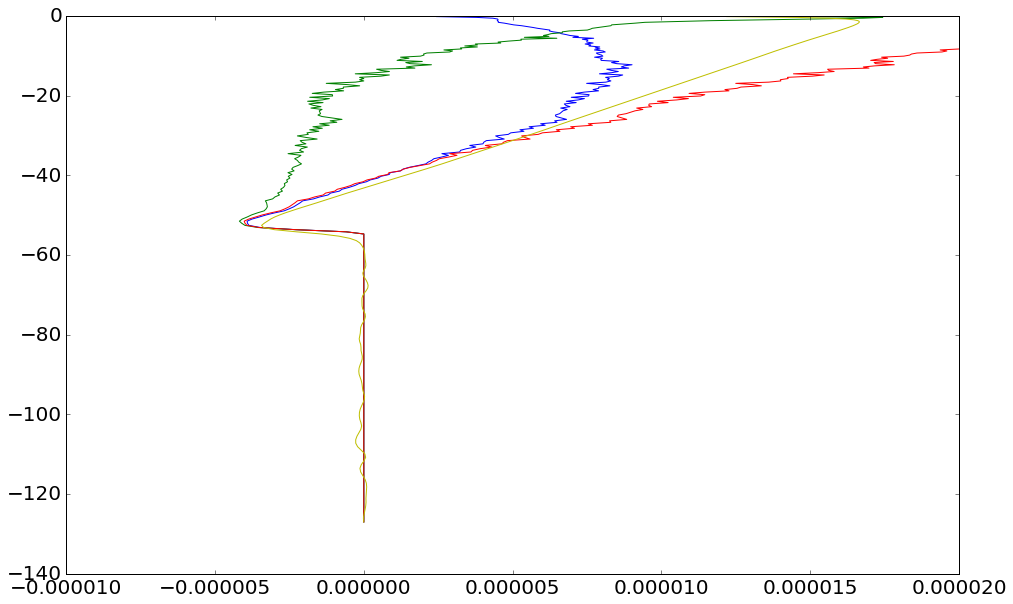

In [163]:
plt.plot(wtloc1[150,:]-wtnloc1[150,:],dsLESAv.ztop[150,1:])
plt.plot(wTloc,dsLESAv.ztop[150,:])
plt.plot(-wTnloc+wTloc,dsLESAv.ztop[150,:])
plt.plot(dsLESAv.wt[150,1:].values,dsLESAv.ztop[5,1:],'y')
plt.xlim(-.00001,0.00002)

In [117]:
ws[150,:10]

array([ 0.00260775,  0.00328904,  0.003769  ,  0.00415273,  0.00447815,
        0.0047638 ,  0.00502032,  0.00525442,  0.00547065,  0.00567225])